# OCR reading and information extraction code for insurance claims in python  

- Developed by : Kinsuk Ghatak
- Month: April, 2023
- LinkedIn: https://www.linkedin.com/in/kinsukghatak/

In [ ]:
## pip install the relevant packages: 
# pip install pytesseract
# pip install tabula-py
# pip install tabulate
# pip install tesseract-ocr
# pip install opencv-python
# pip install pdf2image
# pip install poppler-utils
# sudo apt-get install poppler-utils
# con da install -c conda-forge poppler
# pip install poppler-utils
# !pip install tabula-py
# !pip install tabulate
# !pip install ghostscript
# ! pip install camelot-py

In [1]:
# Import the os module and set the path of the working directory :
import os

# Importing Libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
from matplotlib import pyplot as plt
import seaborn as sns
import cv2 
import pytesseract

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Change the current working directory
os.chdir(r'C:\Users\kghatak003\Desktop\Work\OCR_PoC')
poppler_path = r"C:\Users\kghatak003\Desktop\Work\OCR_PoC\bin\poppler-23.01.0\Library\bin"
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\kghatak003\Desktop\Work\OCR_PoC\tesseract-ocr-w64-setup-5.3.1.20230401.exe"

In [2]:
from PIL import EpsImagePlugin
EpsImagePlugin.gs_windows_binary =  r'C:\Program Files\gs\gs10.01.1\bin\gswin64c'
# im = Image.open('myimage.eps')
# im.save('myimage.png')

## Read the pdf file page by page and convert all the pages to individual jpg files: 

In [4]:

# convert PDF to image then to an array of jpg files ready for opencv processing: 
from pdf2image import convert_from_path
 
 
# Store Pdf with convert_from_path function

images = convert_from_path('New Pip Arb Filing Form.pdf', poppler_path=poppler_path  )
 
for i in range(len(images)):
   
      # Save pages as images in the pdf
    images[i].save('page'+ str(i) +'.jpg', 'JPEG')

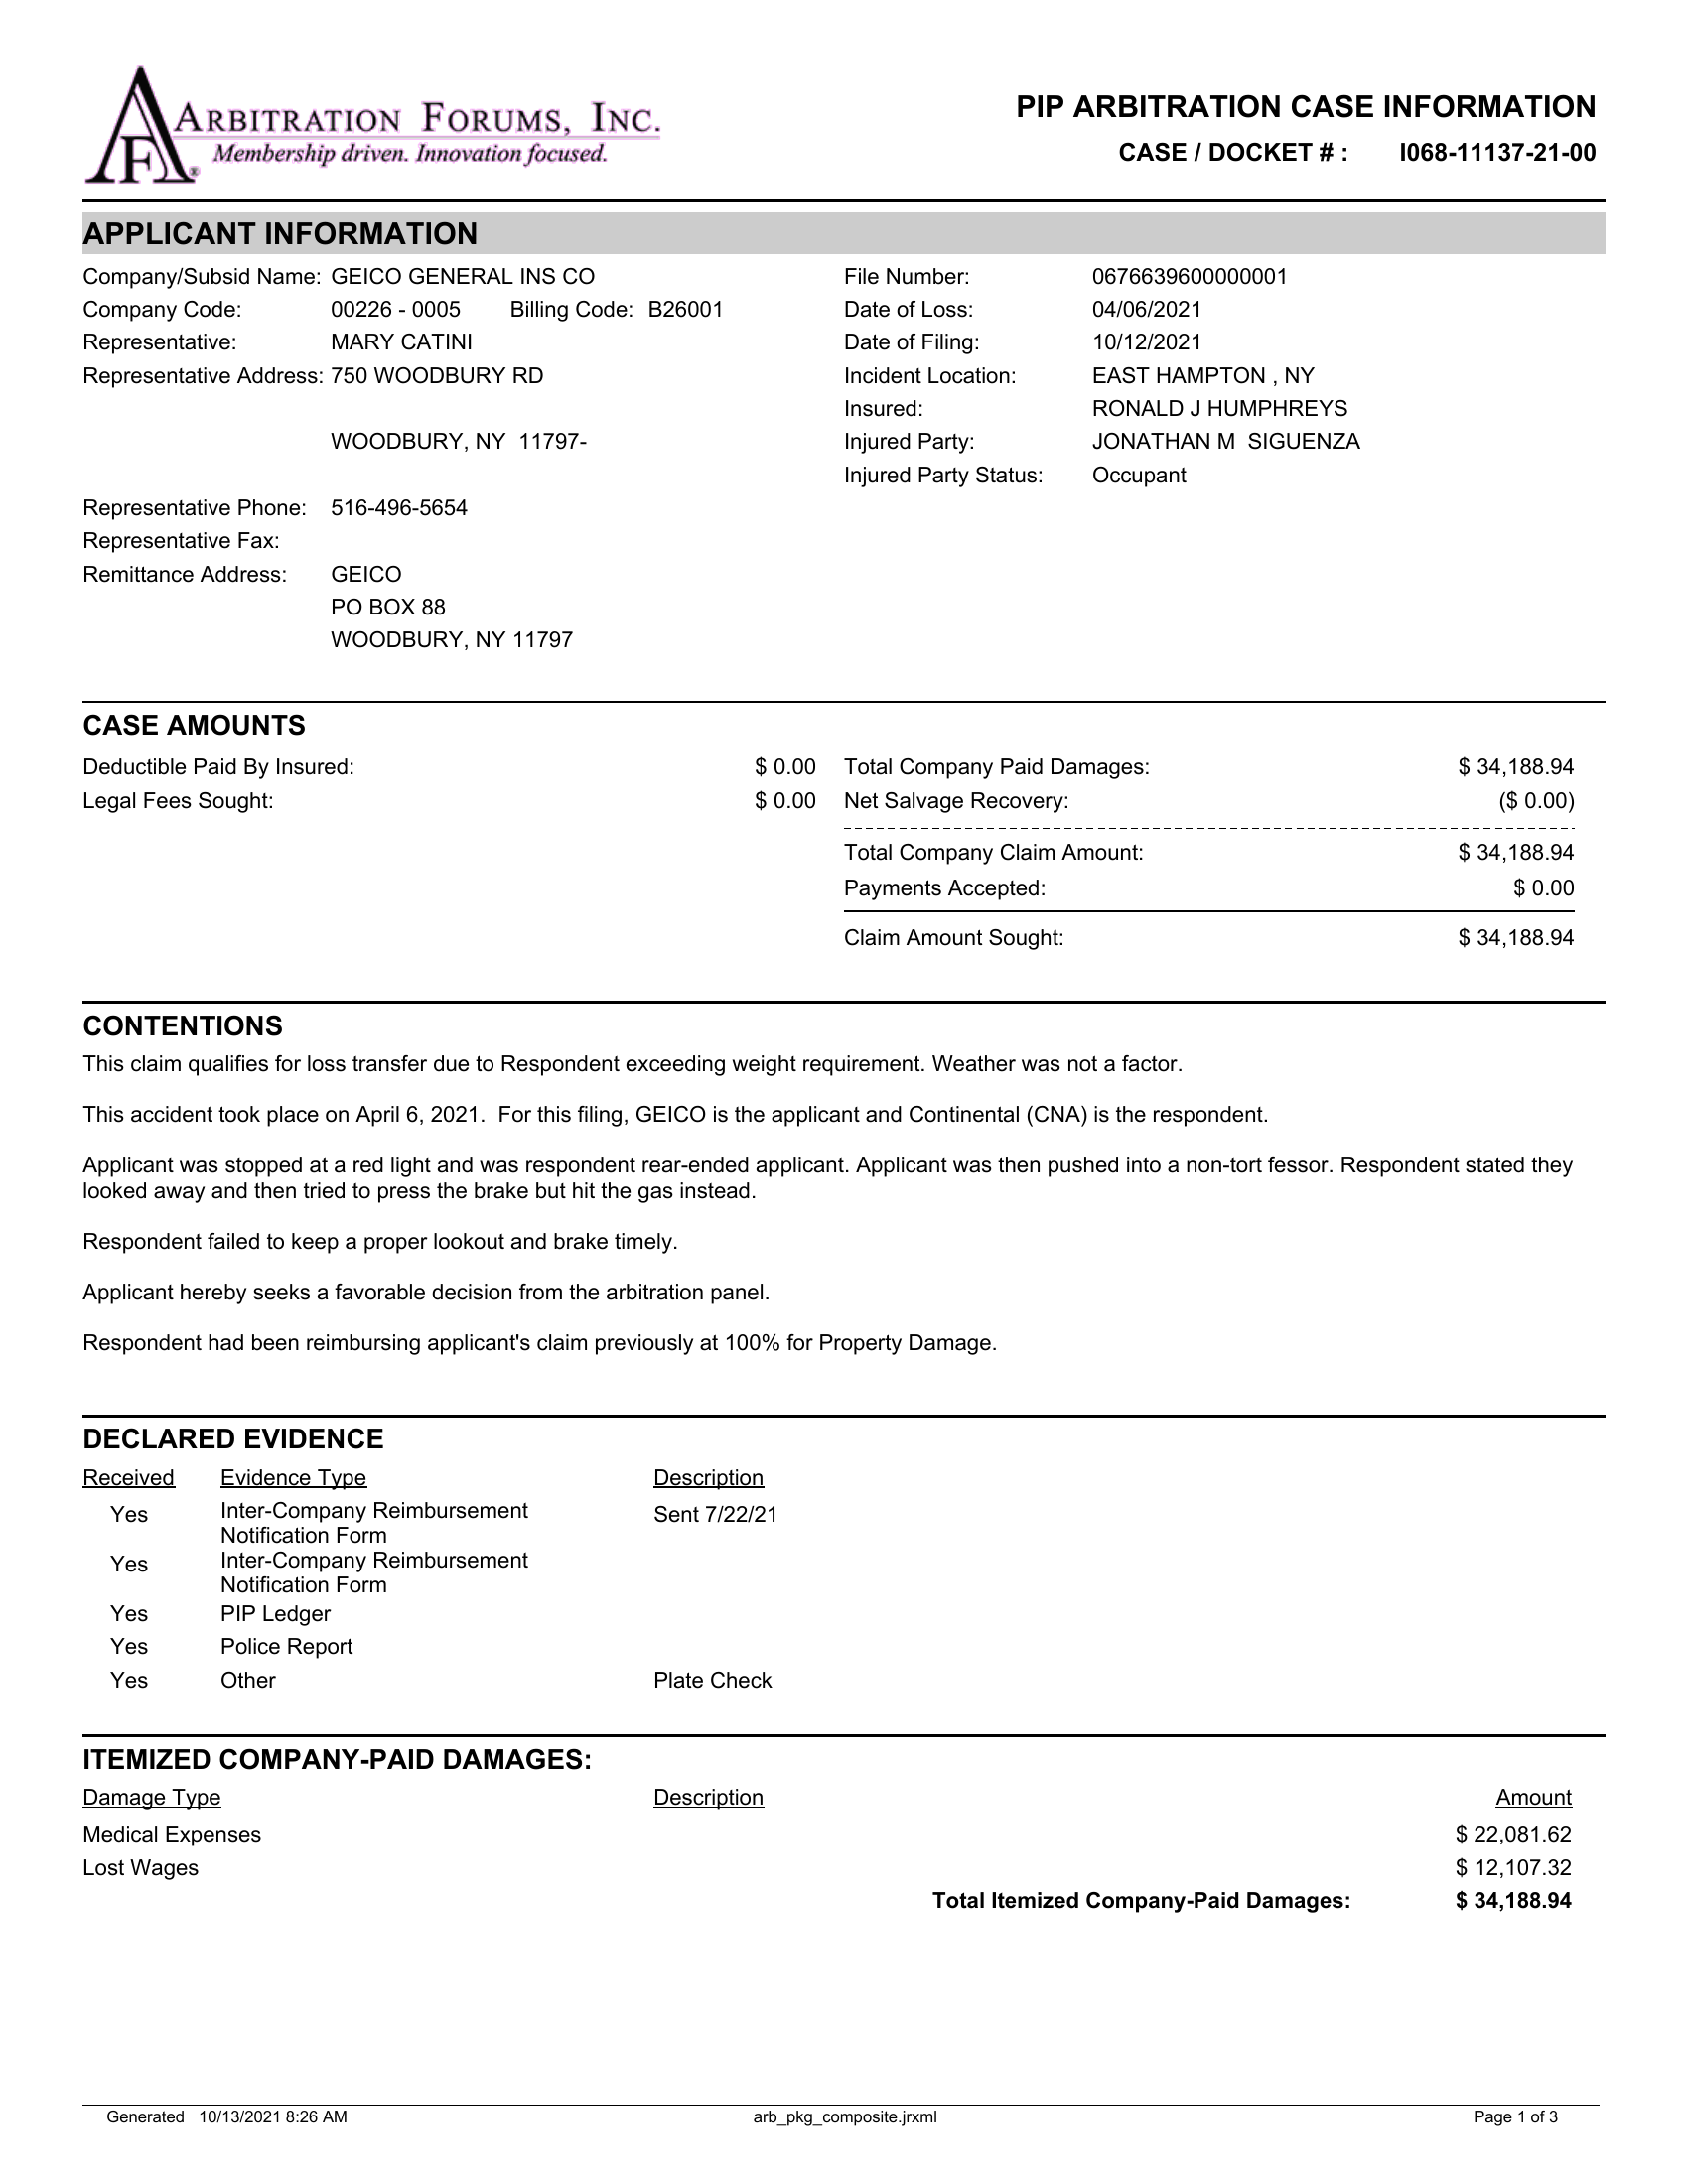

In [11]:
images[0]

## Preprocess the images and extract the text : 

In [17]:
## Preprocess the images:

import cv2
import numpy as np
import pytesseract
import re

img = cv2.imread('page0.jpg')

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)


def image_preprocess(image):
    
    greyscale_img=get_grayscale(image)
    
    removed_noise_img=remove_noise(greyscale_img)
    
    threshold_img=thresholding(removed_noise_img)
    
    dialte_img=dilate(threshold_img)
    
    erode_img=erode(dialte_img)
    
    opening_img=opening(erode_img)
    
    canny_img=canny(opening_img)
    
    return canny_img

img_preprocessed= image_preprocess(img)



# Adding custom options and extract the text 
custom_config = r'--oem 3 --psm 6'
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\kghatak003\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"
text=pytesseract.image_to_string(img)
# text = text.replace("\n", " ")

## Optional : Removing special characters from the text corpus 
def clean(text):
    return re.sub('[^A-Za-z0-9" "]+', ' ', text)

clean_text=clean(text)

clean_text


'ARBITRATION Forums  INC Membership driven  Innovation focused x APPLICANT INFORMATION Company Subsid Name  GEICO GENERAL INS CO Company Code  00226   0005 Billing Code  B26001 Representative  MARY CATINI Representative Address  750 WOODBURY RD WOODBURY  NY 11797 Representative Phone  516 496 5654 Representative Fax Remittance Address  GEICO PO BOX 88 WOODBURY  NY 11797 PIP ARBITRATION CASE INFORMATION CASE   DOCKET  File Number  0676639600000001 Date of Loss  04 06 2021 Date of Filing  10 12 2021 Incident Location  EAST HAMPTON   NY Insured  RONALD J HUMPHREYS Injured Party  JONATHAN M SIGUENZA Injured Party Status  Occupant 1068 11137 21 00 CASE AMOUNTS Deductible Paid By Insured Legal Fees Sought CONTENTIONS 0 00 Total Company Paid Damages    34 188 94 0 00 Net Salvage Recovery    0 00 Total Company Claim Amount    34 188 94 Payments Accepted    0 00 Claim Amount Sought    34 188 94 This claim qualifies for loss transfer due to Respondent exceeding weight requirement  Weather was no

## Use RegEx to extract specific infomration from the text corpus : 

In [18]:
# Extract specific Applicant information from the text using Regex and then convert the information into a table : 

import re

# Define regular expressions for each piece of information
file_number_regex = r'File Number:\s*(\d+)'
date_of_loss_regex = r'Date of Loss:\s*(\d{2}/\d{2}/\d{4})'
company_code_regex = r'Company Code:\s*(\d{5})'
rep_name_regex= "Representative:\s* ([A-Z]+\s[A-Z]+\s)"  
date_of_filing_regex = r'(?:Date of Filing|Filing Date|Claim Booking date):\s*(\d{2}/\d{2}/\d{4})'
insured_party_regex = r'Insured:\s*([\b[A-Z]+(?:\s+[A-Z]+)*\b)' 
claim_amount_regex= r'Claim Amount Sought:\s*([\$ ]+?(\d+([,\.\d]+)?))'
representative_address_regex = r"Representative Address: ([A-Za-z0-9 ,]+)"
representative_phone_regex= r"Representative Phone:\s*(\d{3}-\d{3}-\d{4})"
injured_party_regex=r"Injured Party:\s* ([A-Z]+\s[A-Z]+\s[A-Z]+\s)" 
incident_location_regex=r"Incident Location:\s* ([A-Za-z0-9 ,]+\s)" 
toal_amt_paid_regex=r'Total Itemized Company-Paid Damages:\s*([\$ ]+?(\d+([,\.\d]+)?))'



# Define a function to extract information from the corpus
def extract_information(corpus):
    file_number = re.search(file_number_regex, corpus).group(1)
    date_of_loss = re.search(date_of_loss_regex, corpus).group(1)
    company_code = re.search(company_code_regex, corpus).group(1)
    representative_name=re.search(rep_name_regex, corpus).group(1)
    date_of_filing = re.search(date_of_filing_regex, corpus).group(1)
    insured_party = re.search(insured_party_regex, corpus).group(1)
    claim_amount=re.search(claim_amount_regex, corpus).group(1)
    representative_address=re.search(representative_address_regex, corpus).group(1)
    representative_phone= re.search(representative_phone_regex, corpus).group(1)
    injured_party= re.search(injured_party_regex, corpus).group(1)
    incident_location= re.search(incident_location_regex, corpus).group(1)
    toal_amt_paid= re.search(toal_amt_paid_regex, corpus).group(1)
    
   
    
    # Return a dictionary with the extracted information
    return {
        'File Number': file_number,
        'Date of Loss': date_of_loss,
        'Company Code': company_code,
        'Representative Name' :representative_name,
        'Date of Filing': date_of_filing,
        'Insured Party': insured_party,
        'Claim Amount': claim_amount,
        'Representative Address':representative_address,
        'Representative Phone':representative_phone,
        'Injured Party' : injured_party,
        'Incident Location' : incident_location,
        'Total amount Paid': toal_amt_paid
    }



dict_1=extract_information(text)
info_df=pd.DataFrame(dict_1.items())
info_df.columns=['Applicant Information','Value']
info_df




,Applicant Information,Value
0,File Number,0676639600000001
1,Date of Loss,04/06/2021
2,Company Code,00226
3,Representative Name,MARY CATINI\n
4,Date of Filing,10/12/2021
5,Insured Party,RONALD J HUMPHREYS
6,Claim Amount,"$ 34,188.94"
7,Representative Address,750 WOODBURY RD
8,Representative Phone,516-496-5654
9,Injured Party,JONATHAN M SIGUENZA\n


## Let us now use camelot package to extract tables directly from the PDF reports 

In [28]:
import camelot
tables = camelot.read_pdf('New Pip Arb Filing Form.pdf', pages='all',flavor='stream' ,edge_tol=600)
tables
for i in range(tables.n):
    print(tables[i].parsing_report)
    display(tables[i].df)
   
    

{'accuracy': 96.51, 'whitespace': 33.33, 'order': 1, 'page': 1}


,0,1,2
0,DECLARED EVIDENCE,,
1,Received,Evidence Type,Description
2,Yes,Inter-Company Reimbursement,Sent 7/22/21
3,,Notification Form,
4,Yes,Inter-Company Reimbursement,
5,,Notification Form,
6,Yes,PIP Ledger,
7,Yes,Police Report,
8,Yes,Other,Plate Check


{'accuracy': 95.26, 'whitespace': 61.05, 'order': 2, 'page': 1}


,0,1,2,3
0,,,,PIP ARBITRATION CASE INFORMATION
1,,,CASE / DOCKET # :,I068-11137-21-00
2,APPLICANT INFORMATION,,,
3,Company/Subsid Name:\nGEICO GENERAL INS CO,,File Number:\n0676639600000001,
4,Company Code:\n00226 - 0005,Billing Code:\nB26001,Date of Loss:\n04/06/2021,
5,Representative:\nMARY CATINI,,Date of Filing:\n10/12/2021,
6,Representative Address:\n750 WOODBURY RD,,"Incident Location:\nEAST HAMPTON , NY",
7,,,Insured:\nRONALD J HUMPHREYS,
8,"WOODBURY, NY 11797-",,Injured Party:\nJONATHAN M SIGUENZA,
9,,,Injured Party Status:\nOccupant,


{'accuracy': 97.24, 'whitespace': 52.5, 'order': 1, 'page': 2}


,0,1,2,3,4
0,,,,PIP ARBITRATION CASE INFORMATION,
1,,,,CASE / DOCKET # :,I068-11137-21-00
2,ADMINISTRATIVE,,,,
3,Accept Policy Limits:,No,Request Notice of Hearing:,No,
4,Return Physical Evidence:,No,Personal Rep at Hearing:,No,
5,Three Person Panel Requested:,No,,,
6,Automatic Counter Response:,No,,,
7,Generated\n10/13/2021 8:26 AM,,arb_pkg_composite.jrxml,,Page 2 of 3


{'accuracy': 92.82, 'whitespace': 66.67, 'order': 1, 'page': 3}


,0,1,2,3,4,5
0,,,,,,PIP ARBITRATION CASE INFORMATION
1,,,,,,CASE / DOCKET # :
2,RESPONDENT 1 INFORMATION,,,,,
3,Company/Subsid Name: CONTINENTAL CASUALTY COMPANY,,,,File Number:,W2Y03522
4,Company Code:,03522-0002,Billing Code:,1000914,Insured:,PATRICK BISTRIAN JR INC
5,Representative Name:,AMANDA ROTH,,,,
6,Representative Address:,PO BOX 8317,,,,
7,,"CHICAGO, IL 60680-8317",,,,
8,Representative Phone:,610-320-4738,,,,
9,Representative Fax:,,,,,


In [65]:
tables[0].df

,0,1,2,3,4,5,6
0,,,,,,PIP ARBITRATION CASE INFORMATION,
1,,,,,,CASE / DOCKET # :,I068-11137-21-00
2,APPLICANT INFORMATION,,,,,,
3,Company/Subsid Name:,GEICO GENERAL INS CO,,,File Number:,0676639600000001,
4,Company Code:,00226 - 0005,Billing Code:,B26001,Date of Loss:,04/06/2021,
5,Representative:,MARY CATINI,,,Date of Filing:,10/12/2021,
6,Representative Address:,750 WOODBURY RD,,,Incident Location:,"EAST HAMPTON , NY",
7,,,,,Insured:,RONALD J HUMPHREYS,
8,,"WOODBURY, NY 11797-",,,Injured Party:,JONATHAN M SIGUENZA,
9,,,,,Injured Party Status:,Occupant,


In [26]:
tables[1].df

,0,1,2,3
0,,,,PIP ARBITRATION CASE INFORMATION
1,,,CASE / DOCKET # :,I068-11137-21-00
2,APPLICANT INFORMATION,,,
3,Company/Subsid Name:\nGEICO GENERAL INS CO,,File Number:\n0676639600000001,
4,Company Code:\n00226 - 0005,Billing Code:\nB26001,Date of Loss:\n04/06/2021,
5,Representative:\nMARY CATINI,,Date of Filing:\n10/12/2021,
6,Representative Address:\n750 WOODBURY RD,,"Incident Location:\nEAST HAMPTON , NY",
7,,,Insured:\nRONALD J HUMPHREYS,
8,"WOODBURY, NY 11797-",,Injured Party:\nJONATHAN M SIGUENZA,
9,,,Injured Party Status:\nOccupant,


You can use the plot() method to generate a matplotlib plot of various elements that were detected on the PDF page while processing it. This can help you select table areas, column separators and debug bad table outputs, by tweaking different configuration parameters.

You can specify the type of element you want to plot using the kind keyword argument. The generated plot can be saved to a file by passing a filename keyword argument. The following plot types are supported:

- ‘text’
- ‘grid’
- ‘contour’
- ‘line’
- ‘joint’
- ‘textedge’

(20.0, 100.27999999999999, 581.0039999999999, 752.4547826086957)

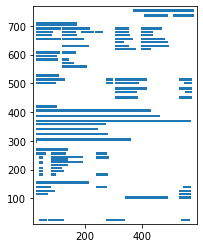

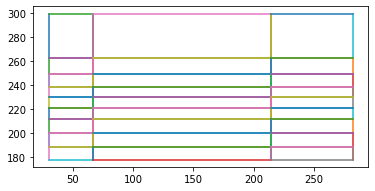

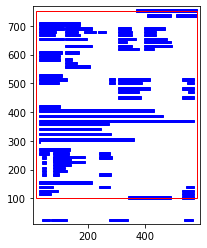

In [48]:
# !pip install camelot-py[plot]
camelot.plot(tables[0], kind='text').show()
camelot.plot(tables[0], kind='grid').show()
camelot.plot(tables[1], kind='contour').show()
tables[1]._bbox